# Adversarial Attacks#

In this report Adversarial Attacks on Neural Networks are considered. 

- Initially three models are trained using common Convolutional Neural Network architectures. 

- Then using the resulting weights the Fast Gradient Sign Method is implemented.

- The results are then compared for different levels of pertubation for all three architectures.


## Importing all the libraries ##

In [2]:
# Import libraries 
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

### Defining our Neural Net ###


# Net

In [3]:
# Neural Network Architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2, 2)
        self.globalavgpool = nn.AvgPool2d(8, 8)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout50 = nn.Dropout(0.5)
        self.dropout10 = nn.Dropout(0.1)
        self.fc = nn.Linear(256, 10)

# Forward function    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout10(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)
        x = self.dropout10(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.globalavgpool(x)
        x = self.dropout50(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Above is a custom architecture the main feautures of this are:

- Three stacked convolutional kernals. Stacked convolutional kernals are very useful and serve two main purposes. Dicounting the first layer if we wish to increase the receptive field of a kernal we should stack two layers on top of eachother. Also it adds non-linearity to the model making it more powerful. 

- Pooling Layers it uses three time average,max and global average pooling. 

- Uses Relu activation function  this is the default activation function and very fast to compute. It does have some issues but they are mostly addressed by its many variants such as leaky Relu and PRelu

- Before the last layer there is a dropout layer to prevent overfitting then the input in flattenend (requires 1D input) so it can be ready for the fully connected layer.

# LeNet-5


In [4]:
# Neural Net architecture for lenet-5
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

# Forward function 
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

Above is the architecture of the lenet-5 Neural Net. It is very simple and consists of only a few hidden layers. It is very famous and was used by the banks to check the digits on hand written cheques. 

# ResNet#

In [5]:
# Neural Net architecture for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

This is the ResNet architecture. It is somewhat more complicated then the preceding Networks. Also it is not a simple FeedFoward Network, where layers are only connected to preceeding layers. We have skip layers now. 

## Define FGSM function

An Adversarial Attack is an attempt to cause a classifier to misclassify an image that it is presented with. Whilst Neural Networks are incredibly powerful and have unrivalled classification rates it is remarkably simple to fool them to misclassify the image they are shown.Part of the problem with Neural Nets is there interpretability.  Humans can perceive things in a way that Neural Nets cannot, but do not think humans cannot be tricked there are numerous illusions that many will be familiar with.  This is a problem if we consider the modern world and AI for example self-driving cars. 

There are several cases or types of attack that can be considered. For instance are we interested in the output class of the image or do we simply require that the image is misclassified ?

Do we have information such as the architecture and weights of the model we wish to fool, or do we just know the output and input classes?

The approach we pursue will depend on the answers to the above and are summarised below.
Targeted (Here we want to fool the classifier to a specific class) / Untargeted (We do not care about the output class just that it is different from the ground truth) / Black box (Nothing about the model weights or its architecture is known only the corresponding inputs and outputs) / White box (All the details of the model are known) 

A single channel 28x28 image is made up of 784 pixels each pixel is represented by its intensity 0-255. 
We wish to fool a classifier subject to the requirement that any alteration that we make to the image be minimal. A norm that penalises changes is needed. Some commonly used are the p norm or l norm. 
The perturbation applied should be imperceptible, that is a human looking at the image should not be able to see the input has been tampered with.
A successful attack is one which fools the classifier without being noticed by the user. 


Here is the fgsm function from the pytorch tutorial. 

The function takes three arguments the base image epsilon the amount of pertubation and the data_gradient. 

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Importing Data and Transform

Torchvision is used to import the data and is used so that we do not need to worry about the preprocessing of the data. It is a very useful tool especially if you are interested in quickly validating your model using a well known dataset.  

Data Augmentation 

- To train a deep Neural Net a large amount of labelled training data is required in the literature around 100K is an often referenced number. This sometimes is often not possible so data augamentation can be used to artificially increase the size of the training data. This is done by applying transformations, rotations and changing the contrast of images. It can increase the size of the data set by around 50x and makes the network invariant to small changes. It regularizes the model and stops overfitting. 



In [0]:
import imgaug.augmenters as iaa
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

pic_size = 32
aug = iaa.Sequential([
        iaa.Affine(
        scale=(0.8, 1.2), 
        rotate=(-5, 5), 
        order=[0],),
        iaa.PadToFixedSize(pic_size, pic_size),
        iaa.CropToFixedSize(pic_size, pic_size),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=1.0)),
        iaa.Sometimes(0.5, iaa.SaltAndPepper(0.06, per_channel=True)),
        ])

In [0]:
class CIFAR10_iaa(datasets.CIFAR10):
    def __getitem__(self, idx):
        pil, target = super().__getitem__(idx)
        img = aug(image=np.array(pil)) / 255
        return img.transpose((2, 0, 1)), target

In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Enter the training and testing batch size 
train_batch_size = 100
test_batch_size = 1

# To use autgrad we must convert to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),])

# Import CIFAR10 and specify batch size 

# Training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

# Testing data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

# Specify the classes in the dataset 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Training of model

### Init Net and Device

In [0]:
# Use the GPU if available to speed up training 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:2")
net = Net().train().to(device)
lenet = LeNet().train().to(device)
resnet = ResNet18().train().to(device)

###Summary of the architecture for all three networks###

In [0]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
         MaxPool2d-3           [-1, 64, 16, 16]               0
           Dropout-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
            Conv2d-6          [-1, 128, 16, 16]         147,584
         AvgPool2d-7            [-1, 128, 8, 8]               0
           Dropout-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
           Conv2d-10            [-1, 256, 8, 8]         590,080
        AvgPool2d-11            [-1, 256, 1, 1]               0
          Dropout-12            [-1, 256, 1, 1]               0
           Linear-13                   [-1, 10]           2,570
Total params: 1,147,978
Trainable param

In [0]:
summary(lenet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [0]:
summary(resnet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Selecting the loss function and optimizer


Selecting the optimiser is very important on large data sets using gradient descent or batch gradient descent is not feasible so we must select another. The default is Stochastic Gradient Descent here Adam is used there are others available and can be experimented with such as RMSPROP, gradient descent with momentum, nestorov gradient descent, nadam and ADAgrad.

Adam is an adaptive variant of Stochastic Gradient Descent. It utilises different learning rates for different parameters.

Also we can see cross entropy loss is used. Cross entropy measures and penalizes our model depending on whether its prediction matches the base truth and the strength of this prediction.

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_net = optim.Adam(net.parameters(), lr=0.001)
optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

### Training and saving the weights of the each model

In [0]:
%%time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_net.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_net.step()
        
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*train_batch_size, loss.item()))

print('Finished Training')
torch.save(net.state_dict(), './cifar10_net.pth')

[1, 10000] loss: 1.9794
[1, 20000] loss: 1.9483
[1, 30000] loss: 1.8016
[1, 40000] loss: 1.6917
[1, 50000] loss: 1.7501
[2, 10000] loss: 1.3842
[2, 20000] loss: 1.6629
[2, 30000] loss: 1.5884
[2, 40000] loss: 1.3742
[2, 50000] loss: 1.4393
[3, 10000] loss: 1.4833
[3, 20000] loss: 1.3559
[3, 30000] loss: 1.1429
[3, 40000] loss: 1.1664
[3, 50000] loss: 1.2280
[4, 10000] loss: 1.0342
[4, 20000] loss: 1.2945
[4, 30000] loss: 1.1462
[4, 40000] loss: 1.0342
[4, 50000] loss: 0.8614
[5, 10000] loss: 1.0971
[5, 20000] loss: 1.2550
[5, 30000] loss: 0.8473
[5, 40000] loss: 1.0403
[5, 50000] loss: 1.2601
[6, 10000] loss: 0.7751
[6, 20000] loss: 0.9899
[6, 30000] loss: 0.9269
[6, 40000] loss: 0.9521
[6, 50000] loss: 1.2919
[7, 10000] loss: 0.9530
[7, 20000] loss: 0.9641
[7, 30000] loss: 0.8921
[7, 40000] loss: 0.6856
[7, 50000] loss: 0.7589
[8, 10000] loss: 0.7285
[8, 20000] loss: 0.7976
[8, 30000] loss: 0.6965
[8, 40000] loss: 0.7635
[8, 50000] loss: 0.8023
[9, 10000] loss: 0.9185
[9, 20000] loss:

In [0]:
%%time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_lenet.zero_grad()
        
        outputs = lenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lenet.step()
        
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*train_batch_size, loss.item()))

print('Finished Training')
torch.save(lenet.state_dict(), './cifar10_lenet.pth')

[1, 10000] loss: 1.9930
[1, 20000] loss: 1.8100
[1, 30000] loss: 1.7825
[1, 40000] loss: 1.6510
[1, 50000] loss: 1.6233
[2, 10000] loss: 1.5035
[2, 20000] loss: 1.4824
[2, 30000] loss: 1.4886
[2, 40000] loss: 1.3122
[2, 50000] loss: 1.2867
[3, 10000] loss: 1.4510
[3, 20000] loss: 1.2409
[3, 30000] loss: 1.3712
[3, 40000] loss: 1.4429
[3, 50000] loss: 1.4198
[4, 10000] loss: 1.4119
[4, 20000] loss: 1.5028
[4, 30000] loss: 1.2956
[4, 40000] loss: 1.3181
[4, 50000] loss: 1.3297
[5, 10000] loss: 1.3137
[5, 20000] loss: 1.0425
[5, 30000] loss: 1.2288
[5, 40000] loss: 1.1652
[5, 50000] loss: 1.4083
[6, 10000] loss: 1.1667
[6, 20000] loss: 1.0497
[6, 30000] loss: 1.2147
[6, 40000] loss: 1.3319
[6, 50000] loss: 1.2546
[7, 10000] loss: 1.1850
[7, 20000] loss: 1.1473
[7, 30000] loss: 1.0790
[7, 40000] loss: 1.0777
[7, 50000] loss: 1.2354
[8, 10000] loss: 1.3227
[8, 20000] loss: 1.0755
[8, 30000] loss: 1.1222
[8, 40000] loss: 1.0981
[8, 50000] loss: 1.1270
[9, 10000] loss: 1.0792
[9, 20000] loss:

In [0]:
%%time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_resnet.zero_grad()
        
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.4f' %(epoch + 1, (i+1)*train_batch_size, loss.item()))

print('Finished Training')
torch.save(resnet.state_dict(), './cifar10_resnet.pth')

[1, 10000] loss: 1.5089
[1, 20000] loss: 1.3168
[1, 30000] loss: 1.0204
[1, 40000] loss: 1.1253
[1, 50000] loss: 0.9807
[2, 10000] loss: 0.9102
[2, 20000] loss: 0.9501
[2, 30000] loss: 0.7660
[2, 40000] loss: 0.7343
[2, 50000] loss: 0.7737
[3, 10000] loss: 0.6693
[3, 20000] loss: 0.4889
[3, 30000] loss: 0.6973
[3, 40000] loss: 0.4404
[3, 50000] loss: 0.4643
[4, 10000] loss: 0.5019
[4, 20000] loss: 0.6043
[4, 30000] loss: 0.5739
[4, 40000] loss: 0.4379
[4, 50000] loss: 0.3641
[5, 10000] loss: 0.6298
[5, 20000] loss: 0.3980
[5, 30000] loss: 0.3773
[5, 40000] loss: 0.5306
[5, 50000] loss: 0.2381
[6, 10000] loss: 0.3737
[6, 20000] loss: 0.2025
[6, 30000] loss: 0.3339
[6, 40000] loss: 0.3689
[6, 50000] loss: 0.4358
[7, 10000] loss: 0.1961
[7, 20000] loss: 0.1781
[7, 30000] loss: 0.2591
[7, 40000] loss: 0.1740
[7, 50000] loss: 0.2989
[8, 10000] loss: 0.1120
[8, 20000] loss: 0.1174
[8, 30000] loss: 0.2890
[8, 40000] loss: 0.1232
[8, 50000] loss: 0.3048
[9, 10000] loss: 0.0835
[9, 20000] loss:

### Load weights

In [0]:
# Loading the weights of the pretrained models
net.load_state_dict(torch.load('./cifar10_net.pth', map_location='cpu'))
lenet.load_state_dict(torch.load('./cifar10_lenet.pth', map_location='cpu'))
resnet.load_state_dict(torch.load('./cifar10_resnet.pth', map_location='cpu'))

<All keys matched successfully>

### Evaluate the mode & fix the weights

In [0]:
net.eval()
for p in net.parameters():
    p.requires_grad = False

In [0]:
lenet.eval()
for p in lenet.parameters():
    p.requires_grad = False

In [0]:
resnet.eval()
for p in resnet.parameters():
    p.requires_grad = False

### Accuracy of the Net model 

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the Net network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
#           class_correct[label] += c[i].item()
            class_correct[label] += c.item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Net Network: Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the Net network on the 10000 test images: 77 %
Net Network: Accuracy of plane : 78 %
Net Network: Accuracy of   car : 92 %
Net Network: Accuracy of  bird : 72 %
Net Network: Accuracy of   cat : 55 %
Net Network: Accuracy of  deer : 73 %
Net Network: Accuracy of   dog : 59 %
Net Network: Accuracy of  frog : 83 %
Net Network: Accuracy of horse : 81 %
Net Network: Accuracy of  ship : 89 %
Net Network: Accuracy of truck : 86 %


### Accuracy of the LeNet-5 model 

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the LeNet network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = lenet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
#           class_correct[label] += c[i].item()
            class_correct[label] += c.item()
            class_total[label] += 1
 
 
for i in range(10):
    print('LeNet Network: Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the LeNet network on the 10000 test images: 61 %
LeNet Network: Accuracy of plane : 70 %
LeNet Network: Accuracy of   car : 72 %
LeNet Network: Accuracy of  bird : 52 %
LeNet Network: Accuracy of   cat : 26 %
LeNet Network: Accuracy of  deer : 49 %
LeNet Network: Accuracy of   dog : 59 %
LeNet Network: Accuracy of  frog : 72 %
LeNet Network: Accuracy of horse : 67 %
LeNet Network: Accuracy of  ship : 71 %
LeNet Network: Accuracy of truck : 72 %


### Accuracy of the ResNet model 

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the ResNet network on the 10000 test images: %d %%' % (
    100 * correct / total))
 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            label = labels[i]
#           class_correct[label] += c[i].item()
            class_correct[label] += c.item()
            class_total[label] += 1
 
 
for i in range(10):
    print('ResNet Network: Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the ResNet network on the 10000 test images: 83 %
ResNet Network: Accuracy of plane : 86 %
ResNet Network: Accuracy of   car : 91 %
ResNet Network: Accuracy of  bird : 78 %
ResNet Network: Accuracy of   cat : 74 %
ResNet Network: Accuracy of  deer : 78 %
ResNet Network: Accuracy of   dog : 71 %
ResNet Network: Accuracy of  frog : 82 %
ResNet Network: Accuracy of horse : 87 %
ResNet Network: Accuracy of  ship : 89 %
ResNet Network: Accuracy of truck : 93 %


Interestingly all three networks they had simarlaly poor performance on the bird,cat,deer and dog classes. It is only possible to speculate why this may be as with only this information it cannot be known for certain ,as it appears in all three there it is likely some underlying cause is responsible. A possible approach would be to check the correlation between these classes. 

### Adversarial Attack using FGSM

In [0]:
# Here we define the function that tests our model
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Here we run the attacks and evaluate the accuracy for different values of epsilon

In [0]:
%%time
accuracies_net = []
examples_net = []
epsilons_net = [0, .01, .02, .03, .04, .05, .06,.07,.08,.09,.1]
# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_net:
    acc, ex = test(net, device, testloader, eps)
    accuracies_net.append(acc)
    examples_net.append(ex)

Epsilon: 0	Test Accuracy = 8264 / 10000 = 0.8264
Epsilon: 0.01	Test Accuracy = 3861 / 10000 = 0.3861
Epsilon: 0.02	Test Accuracy = 1898 / 10000 = 0.1898
Epsilon: 0.03	Test Accuracy = 1169 / 10000 = 0.1169
Epsilon: 0.04	Test Accuracy = 898 / 10000 = 0.0898
Epsilon: 0.05	Test Accuracy = 782 / 10000 = 0.0782
Epsilon: 0.06	Test Accuracy = 738 / 10000 = 0.0738
Epsilon: 0.07	Test Accuracy = 710 / 10000 = 0.071
Epsilon: 0.08	Test Accuracy = 682 / 10000 = 0.0682
Epsilon: 0.09	Test Accuracy = 681 / 10000 = 0.0681
Epsilon: 0.1	Test Accuracy = 697 / 10000 = 0.0697
CPU times: user 6min 3s, sys: 30 s, total: 6min 33s
Wall time: 7min 18s


In [0]:
%%time
accuracies_net2 = []
examples_net2 = []
epsilons_net2 = [0, .02, .04, .06, .08, .1, .12,.14,.16,.18,.2]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_net2:
    acc, ex = test(net, device, testloader, eps)
    accuracies_net2.append(acc)
    examples_net2.append(ex)

Epsilon: 0	Test Accuracy = 8264 / 10000 = 0.8264
Epsilon: 0.02	Test Accuracy = 1898 / 10000 = 0.1898
Epsilon: 0.04	Test Accuracy = 898 / 10000 = 0.0898
Epsilon: 0.06	Test Accuracy = 738 / 10000 = 0.0738
Epsilon: 0.08	Test Accuracy = 682 / 10000 = 0.0682
Epsilon: 0.1	Test Accuracy = 697 / 10000 = 0.0697
Epsilon: 0.12	Test Accuracy = 712 / 10000 = 0.0712
Epsilon: 0.14	Test Accuracy = 722 / 10000 = 0.0722
Epsilon: 0.16	Test Accuracy = 738 / 10000 = 0.0738
Epsilon: 0.18	Test Accuracy = 755 / 10000 = 0.0755
Epsilon: 0.2	Test Accuracy = 752 / 10000 = 0.0752
CPU times: user 6min 6s, sys: 29.9 s, total: 6min 36s
Wall time: 7min 21s


In [0]:
%%time
accuracies_net3 = []
examples_net3 = []
epsilons_net3 = [0, .05, .1, .15, .2, .25, .3,.35,.4,.45,.5]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_net3:
    acc, ex = test(net, device, testloader, eps)
    accuracies_net3.append(acc)
    examples_net3.append(ex)

Epsilon: 0	Test Accuracy = 8264 / 10000 = 0.8264
Epsilon: 0.05	Test Accuracy = 782 / 10000 = 0.0782
Epsilon: 0.1	Test Accuracy = 697 / 10000 = 0.0697
Epsilon: 0.15	Test Accuracy = 714 / 10000 = 0.0714
Epsilon: 0.2	Test Accuracy = 752 / 10000 = 0.0752
Epsilon: 0.25	Test Accuracy = 758 / 10000 = 0.0758
Epsilon: 0.3	Test Accuracy = 801 / 10000 = 0.0801
Epsilon: 0.35	Test Accuracy = 818 / 10000 = 0.0818
Epsilon: 0.4	Test Accuracy = 871 / 10000 = 0.0871
Epsilon: 0.45	Test Accuracy = 900 / 10000 = 0.09
Epsilon: 0.5	Test Accuracy = 926 / 10000 = 0.0926
CPU times: user 6min 8s, sys: 29.4 s, total: 6min 37s
Wall time: 7min 23s


In [0]:
accuracies_lenet = []
examples_lenet = []
epsilons_lenet = [0, .01, .02, .03, .04, .05, .06,.07,.08,.09,.1]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_lenet:
    acc, ex = test(lenet, device, testloader, eps)
    accuracies_lenet.append(acc)
    examples_lenet.append(ex)

Epsilon: 0	Test Accuracy = 6161 / 10000 = 0.6161
Epsilon: 0.01	Test Accuracy = 2570 / 10000 = 0.257
Epsilon: 0.02	Test Accuracy = 1049 / 10000 = 0.1049
Epsilon: 0.03	Test Accuracy = 444 / 10000 = 0.0444
Epsilon: 0.04	Test Accuracy = 211 / 10000 = 0.0211
Epsilon: 0.05	Test Accuracy = 110 / 10000 = 0.011
Epsilon: 0.06	Test Accuracy = 82 / 10000 = 0.0082
Epsilon: 0.07	Test Accuracy = 69 / 10000 = 0.0069
Epsilon: 0.08	Test Accuracy = 60 / 10000 = 0.006
Epsilon: 0.09	Test Accuracy = 57 / 10000 = 0.0057
Epsilon: 0.1	Test Accuracy = 50 / 10000 = 0.005


In [0]:
accuracies_resnet = []
examples_resnet = []
epsilons_resnet = [0, .01, .02, .03, .04, .05, .06,.07,.08,.09,.1]

# Run test for each epsilon
# testloader batchsize should be 1
for eps in epsilons_resnet:
    acc, ex = test(resnet, device, testloader, eps)
    accuracies_resnet.append(acc)
    examples_resnet.append(ex)

Epsilon: 0	Test Accuracy = 8320 / 10000 = 0.832
Epsilon: 0.01	Test Accuracy = 1449 / 10000 = 0.1449
Epsilon: 0.02	Test Accuracy = 433 / 10000 = 0.0433
Epsilon: 0.03	Test Accuracy = 235 / 10000 = 0.0235
Epsilon: 0.04	Test Accuracy = 176 / 10000 = 0.0176
Epsilon: 0.05	Test Accuracy = 155 / 10000 = 0.0155
Epsilon: 0.06	Test Accuracy = 132 / 10000 = 0.0132
Epsilon: 0.07	Test Accuracy = 132 / 10000 = 0.0132
Epsilon: 0.08	Test Accuracy = 131 / 10000 = 0.0131
Epsilon: 0.09	Test Accuracy = 141 / 10000 = 0.0141
Epsilon: 0.1	Test Accuracy = 144 / 10000 = 0.0144


### Plots showing the Accuracy vs Epsilon Plots 

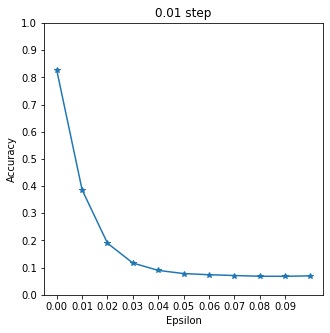

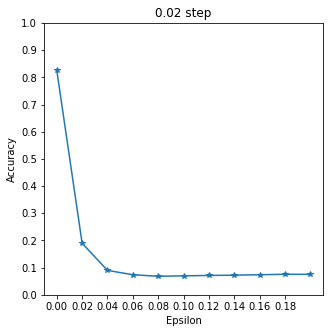

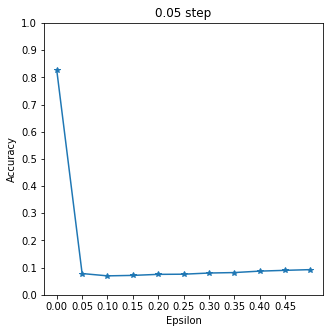

In [0]:
# Plot of Accuracy vs Epsilon with 0.01 step size 
plt.figure(figsize=(5,5))
plt.plot(epsilons_net, accuracies_net, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .1, step=0.01))
plt.title("0.01 step")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Plot of Accuracy vs Epsilon with 0.02 step size 
plt.figure(figsize=(5,5))
plt.plot(epsilons_net2, accuracies_net2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .2, step=0.02))
plt.title("0.02 step")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Plot of Accuracy vs Epsilon with 0.05 step size 
plt.figure(figsize=(5,5))
plt.plot(epsilons_net3, accuracies_net3, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .5, step=0.05))
plt.title("0.05 step")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Changing the epsilon value beyond a certain point does not seem to further deteriorate the rate of misclassification in this case around 0.05. This pertubation is small especially compared with the epsillon required in a single channel greyscale image like FashionMNIST. Models that classify three channel images are less robust to adversarial attacks it seems. 

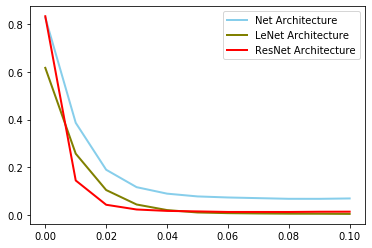

In [0]:
# Using matplotlib to plot the degradation in accuracy for three different architectures 
plt.plot( epsilons_net, accuracies_net, color='skyblue', linewidth=2, label="Net Architecture")
plt.plot( epsilons_lenet, accuracies_lenet, color='olive', linewidth=2, label="LeNet Architecture")
plt.plot( epsilons_resnet, accuracies_resnet, color='red',linewidth=2, label="ResNet Architecture")
plt.legend()

The three architectures and there response to adversarial attacks. 

The best performing architecture seems to be the least robust. Why this could be? It could be overfitting. 

LeNet performed poorly on the training set it is not surprising that a larger pertubation is required to fool this model. 

Conclusion and summary 

Three Neural Networks were trained then attacked using the fast gradient sign method their robustness varied.

To protect our model we could train it using some adversarial examples, this however would reduce the accuracy of our training data i.e it would be a worse classifier and for that reason it would be harder to attack.  There are other techniques that could be used however there is no simple way to combat adversarial examples what is required is an adaptive method which does not exist.

Further Reading 

- Adversarial training can result in regularization even further regularization than dropout. 

- Models that are easy to optimize are easy to perturb.

- Ensembles are not resistant to adversarial examples.


